In [1]:
'------------------------------------------------- Initial Setup -------------------------------------------------'

%matplotlib inline
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from pprint import pprint
from itertools import cycle
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.externals import joblib
from xgboost.sklearn import XGBClassifier
from TrainTestSplit import trainTestSplit
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score


np.set_printoptions(precision = 2)

In [2]:
## Loading in the data of Set B.
XTrain, XTest, YTrain, YTest = trainTestSplit("B")

In [3]:
## Setting the classifier to be Vanilla XGBoostClassifier.
Classifier = XGBClassifier()

## Defining a list to store the Cross-Validation Scores.
crossValidationScores = []

## Computing the 10-fold cross-validation score.
cvScore = cross_val_score(Classifier, XTrain, YTrain['FTR'], cv = 10)
crossValidationScores.append(np.mean(cvScore))
print "Cross Validation Score : ", np.mean(crossValidationScores)

## Computing the Training and Testing Accuracies.
Classifier.fit(XTrain,YTrain)
print "Training Accuracy : ", Classifier.score(XTrain, YTrain)
print "Testing Accuracy : ", Classifier.score(XTest, YTest)

Cross Validation Score :  0.533177412531
Training Accuracy :  0.583024779265
Testing Accuracy :  0.571875


In [4]:
## Defining the hyperparameter space for searching the optimum set of hyperparameter values .
parameters = { 'max_depth' : [3, 5, 6, 9, 12, 15, 17, 25],
               'gamma' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5],
               'learning_rate' : [0.01, 0.025, 0.05, 0.1],
               'reg_lambda' : [0.01, 0.025, 0.075, 0.1, 0.2, 0.6, 1.0, 0.05]
              }

In [5]:
# # Uncomment this block if you want to run the grid search yourself.
# # Note : This is going to be computationally very expensive on your CPU !

# Clf1 = GridSearchCV(Classifier, parameters, n_jobs = 5, verbose = 4, scoring = 'accuracy')

# ## Fitting the Model to the Training Data.
# Clf1.fit(XTrain, YTrain.values.ravel())

# # Saving the grid search object.
# joblib.dump(Clf1, './GridSearchObjects/XGBSetB.pkl')

In [6]:
# Loading the already tuned model with the above set of hyperparameters.
Clf = joblib.load('./GridSearchObjects/XGBSetB.pkl')

In [7]:
## Printing the statistics after hyper-parameter tuning.
print Clf.best_score_
print Clf.best_estimator_

0.536029621191
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.5, learning_rate=0.025,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=0.6, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)


In [8]:
## Setting the classifier to be the hyperparameter tuned Random Forest Classifier.
Classifier = Clf.best_estimator_

## Defining a list to store the Cross-Validation Scores.
crossValidationScores = []

## Computing the 10-fold cross-validation score.
cvScore = cross_val_score(Classifier, XTrain, YTrain['FTR'], cv = 10)
crossValidationScores.append(np.mean(cvScore))
print "Cross Validation Score : ", np.mean(crossValidationScores)

## Computing the Training and Testing Accuracies.
Classifier.fit(XTrain,YTrain)
print "Training Accuracy : ", Classifier.score(XTrain, YTrain)
print "Testing Accuracy : ", Classifier.score(XTest, YTest)

Cross Validation Score :  0.53345341415
Training Accuracy :  0.552549131302
Testing Accuracy :  0.5765625


In [9]:
## Obtaining our predictions made by the best Gaussian Naive Bayes Classifier .
YPred = Classifier.predict(XTest)

## Defining the target classes .
classLabels = ['H','A','D']

## Obtaining the confusion matrix for our predictions .
confusionMatrix = confusion_matrix(YTest['FTR'], YPred, classLabels)

In [10]:
## Obtaining a more readable format of our Confusion Matrix in terms of a Classification Report . 

classificationReport = classification_report(YTest, YPred, classLabels)
print classificationReport

             precision    recall  f1-score   support

          H       0.58      0.88      0.70       308
          A       0.57      0.56      0.57       174
          D       0.20      0.01      0.01       158

avg / total       0.49      0.58      0.49       640



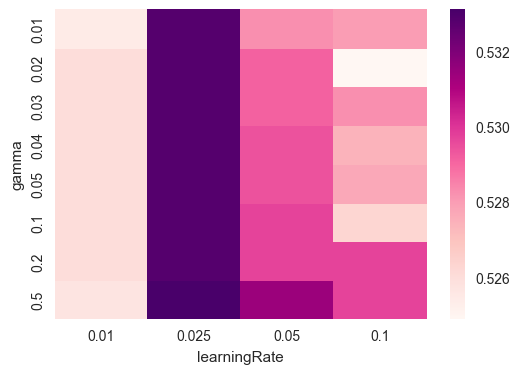

In [18]:
gridScores = Clf.grid_scores_

gridScoresList = []

for i in range(0, len(gridScores)):

    Score = (gridScores[i][1],)
    learningRate = (gridScores[i][0]['learning_rate'],)
    gamma = (gridScores[i][0]['gamma'],)

    Tuple = Score + learningRate + gamma
    gridScoresList.append(Tuple)
    
df = pd.DataFrame(gridScoresList, columns = ['Validation Score', 'learningRate', 'gamma'])
df = df.drop_duplicates(subset = ['learningRate', 'gamma'])
## df = df[np.isfinite(df['maxDepth'])]

gridMap = df.pivot("gamma", "learningRate", "Validation Score")
sns.heatmap(gridMap, cmap = "RdPu")

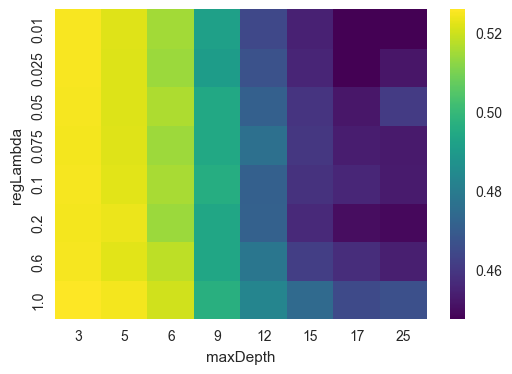

In [16]:
gridScores = Clf.grid_scores_

gridScoresList = []

for i in range(0, len(gridScores)):

    Score = (gridScores[i][1],)
    regLambda = (gridScores[i][0]['reg_lambda'],)
    maxDepth = (gridScores[i][0]['max_depth'],)

    Tuple = Score + regLambda + maxDepth
    gridScoresList.append(Tuple)
    
df = pd.DataFrame(gridScoresList, columns = ['Validation Score', 'regLambda', 'maxDepth'])
df = df.drop_duplicates(subset = ['regLambda', 'maxDepth'])

gridMap = df.pivot("regLambda", "maxDepth", "Validation Score")
sns.heatmap(gridMap, cmap = "viridis")